### Load Images and Captions

In [1]:
# load the file containing all of the captions into a single long string
caption_file = "E:\\AI Mini Project\\dataset\\Flickr8k.token.txt"
def load_captions (filename):
  with open(filename, "r") as fp:
    # Read all text in the file
    text = fp.read()
    return (text)

# Each photo has a unique identifier, which is the file name of the image .jpg file
# Create a dictionary of photo identifiers (without the .jpg) to captions. Each photo identifier maps to
# a list of one or more textual descriptions.
#
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
def captions_dict (text):
  dict = {}
  
  # Make a List of each line in the file
  lines = text.split ('\n')
  for line in lines:
    
    # Split into the <image_data> and <caption>
    line_split = line.split ('\t')
    if (len(line_split) != 2):
      # Added this check because dataset contains some blank lines
      continue
    else:
      image_data, caption = line_split

    # Split into <image_file> and <caption_idx>
    image_file, caption_idx = image_data.split ('#')
    # Split the <image_file> into <image_name>.jpg
    image_name = image_file.split ('.')[0]
    
    # If this is the first caption for this image, create a new list for that
    # image and add the caption to it. Otherwise append the caption to the 
    # existing list
    if (int(caption_idx) == 0):
      dict [image_name] = [caption]
    else:
      dict [image_name].append (caption)
  
  return (dict)

doc = load_captions (caption_file)
image_dict = captions_dict (doc)


In [3]:
#image_dict
first2pairs = {k: image_dict[k] for k in list(image_dict)[:2]}
first2pairs

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .']}

### Selecting subset of dataset to use for training

In [4]:
# We have three separate files which contain the names for the subset of 
# images to be used for training, validation or testing respectively
#
# Given a file, we return a set of image names (without .jpg extension) in that file

def subset_image_name (filename):
  data = []
  
  with open(filename, "r") as fp:
    # Read all text in the file
    text = fp.read()
  
    # Make a List of each line in the file
    lines = text.split ('\n')
    for line in lines:
      # skip empty lines
      if (len(line) < 1):
        continue
      
      # Each line is the <image_file>
      # Split the <image_file> into <image_name>.jpg
      image_name = line.split ('.')[0]
      
      # Add the <image_name> to the list
      data.append (image_name)

    return (set(data))  

training_image_name_file = "E:\\AI Mini Project\\dataset\\Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)

### Pre-processing 
+ Use a pre-trained Inception model which is a well-known Image Classification model
+ This model consists of two sections:
 + The first section consists of a sequence of CNN layers that progressively extract the relevant features from the image to produce a compact feature map representation.
 + The second section is the Classifier that consists of a sequence of Linear layers. It takes the image feature map and predicts a class (eg. dog, car, house, etc) to which the feature belongs.

+ For our Image Caption model, we need only the image feature maps, and do not need the Classifier.

In [5]:
import tensorflow as tf

In [6]:
import numpy as np

In [7]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path
    
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

from tqdm import tqdm

image_dir = "E:\\AI Mini Project\\dataset\\Flicker8k_Dataset\\"
training_image_paths = [image_dir + name + '.jpg' for name in training_image_names]

# Get unique images
encode_train = sorted(set(training_image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [09:35<00:00,  1.53s/it]


### Preparing Captions
+ Cleaning
+ Add tokens
+ Tokenize the sentence by mapping each word to a numeric word ID. It does this by building a vocabulary of all the words that occur in the set of captions.
+ Extend each sentence to the same length by appending padding tokens. This is needed because the model expects every data sample to have the same fixed length.

In [8]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import re

#    Clean the captions data
#    Convert all words to lowercase.
#    Remove all punctuation.
#    Remove all words that are one character or less in length (e.g. ‘a’).
#    Remove all words with numbers in them.

def captions_clean (image_dict):
  # <key> is the image_name, which can be ignored
  for key, captions in image_dict.items():
    
    # Loop through each caption for this image
    for i, caption in enumerate (captions):
      
      # Convert the caption to lowercase, and then remove all special characters from it
      caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
      
      # Split the caption into separate words, and collect all words which are more than 
      # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
      clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]
      
      # Join those words into a string
      caption_new = ' '.join(clean_words)
      
      # Replace the old caption in the captions list with this new cleaned caption
      captions[i] = caption_new
      
# Add two tokens, 'startseq' and 'endseq' at the beginning and end respectively, 
# of every caption
def add_token (captions):
  for i, caption in enumerate (captions):
    captions[i] = 'startseq ' + caption + ' endseq'
  return (captions)


# Given a set of training, validation or testing image names, return a dictionary
# containing the corresponding subset from the full dictionary of images with captions
#
# This returned subset has the same structure as the full dictionary
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}

def subset_data_dict (image_dict, image_names):
  dict = { image_name:add_token(captions) for image_name,captions in image_dict.items() if image_name in image_names}
  return (dict)


# Flat list of all captions

def all_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])


# Calculate the word-length of the caption with the most words

def max_caption_length(captions):
  return max(len(caption.split()) for caption in captions)


# Fit a Keras tokenizer given caption descriptions
# The tokenizer uses the captions to learn a mapping from words to numeric word indices
#
# Later, this tokenizer will be used to encode the captions as numbers

def create_tokenizer(data_dict):
  captions = all_captions(data_dict)
  max_caption_words = max_caption_length(captions)
  
  # Initialise a Keras Tokenizer
  tokenizer = Tokenizer()
  
  # Fit it on the captions so that it prepares a vocabulary of all words
  tokenizer.fit_on_texts(captions)
  
  # Get the size of the vocabulary
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)


# Extend a list of text indices to a given fixed length

def pad_text (text, max_length): 
  text = pad_sequences([text], maxlen=max_length, padding='post')[0]
  
  return (text)

captions_clean (image_dict)
training_dict = subset_data_dict (image_dict, training_image_names)

# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

### Prepare Training Data using a Tensorflow Dataset
+ We now have pre-processed images and captions. 
+ We go through every training image and its matching captions to prepare the training data. 

In [9]:
import numpy as np

def data_prep(data_dict, tokenizer, max_length, vocab_size):
  X, y = list(), list()

  # For each image and list of captions
  for image_name, captions in data_dict.items():
    image_name = image_dir + image_name + '.jpg'

    # For each caption in the list of captions
    for caption in captions:

      # Convert the caption words into a list of word indices
      word_idxs = tokenizer.texts_to_sequences([caption])[0]

      # Pad the input text to the same fixed length
      pad_idxs = pad_text(word_idxs, max_length)
          
      X.append(image_name)
      y.append(pad_idxs)
  
  return np.array(X), np.array(y)
  return X, y

train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, vocab_size)

In [10]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [11]:
"""
Image Caption Model with Attention
The model consists of four logical components:

Encoder: since the image encoding has already been done by the pre-trained Inception model, 
         the Encoder here is very simple. It consists of a Linear layer that takes the pre-encoded 
         image features and passes them on to the Decoder.
Sequence Decoder: this is a recurrent network built with GRUs. 
                  The captions are passed in as the input after first going through an Embedding layer.
Attention: as the Decoder generates each word of the output sequence, 
           the Attention module helps it to focus on the most relevant part of the image for generating that word.
Sentence Generator: this module consists of a couple of Linear layers. 
                    It takes the output from the Decoder and produces a probability for each word from the vocabulary, for each position in the predicted sequence.

"""
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [12]:
# At each timestep, the Attention module takes the encoded image as input along with 
# the Decoder’s hidden state for the previous timestep.
# It produces an Attention Score that assigns a weight to each pixel of the encoded image. 
# The higher the weight for a pixel, the more relevant it is for the word to be output at the next timestep.

# training the model

embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

import time
start_epoch = 0
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Epoch 1 Batch 0 Loss 2.7572
Epoch 1 Batch 100 Loss 1.5157
Epoch 1 Batch 200 Loss 1.3284
Epoch 1 Batch 300 Loss 1.1520
Epoch 1 Batch 400 Loss 1.1925
Epoch 1 Loss 1.399943
Time taken for 1 epoch 1007.48 sec

Epoch 2 Batch 0 Loss 1.2152
Epoch 2 Batch 100 Loss 1.1616
Epoch 2 Batch 200 Loss 1.0613
Epoch 2 Batch 300 Loss 1.0488
Epoch 2 Batch 400 Loss 1.0573
Epoch 2 Loss 1.092991
Time taken for 1 epoch 900.55 sec

Epoch 3 Batch 0 Loss 1.0967
Epoch 3 Batch 100 Loss 0.9606
Epoch 3 Batch 200 Loss 0.9326
Epoch 3 Batch 300 Loss 0.9573
Epoch 3 Batch 400 Loss 0.9440
Epoch 3 Loss 0.979110
Time taken for 1 epoch 905.53 sec

Epoch 4 Batch 0 Loss 0.9899
Epoch 4 Batch 100 Loss 0.8425
Epoch 4 Batch 200 Loss 0.9408
Epoch 4 Batch 300 Loss 0.8144
Epoch 4 Batch 400 Loss 0.8201
Epoch 4 Loss 0.902270
Time taken for 1 epoch 939.80 sec

Epoch 5 Batch 0 Loss 0.8277
Epoch 5 Batch 100 Loss 0.8407
Epoch 5 Batch 200 Loss 0.8480
Epoch 5 Batch 300 Loss 0.7780
Epoch 5 Batch 400 Loss 0.7670
Epoch 5 Loss 0.839455
Time take

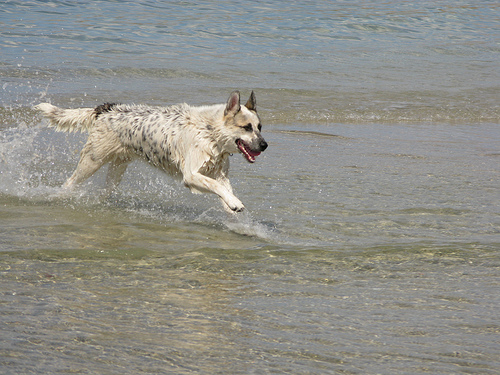

Real Caption: ['pale colored dog runs through body of water', 'white dog is running through the water at beach', 'white dog is running through the water onto the shore', 'the white dog runs through the ocean', 'white medium sized dog is running through the ocean']
Prediction Caption: brown and white dog is walking through shallow water endseq
BLEU-1: 0.500000
BLEU-2: 0.333333
BLEU-3: 0.277204
BLEU-4: 0.000000


In [61]:

def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],-1,img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot
  
def check_test(test_image_names, image_dict, image_dir, max_caption_words):
# captions on the validation set
    rid = np.random.randint(0, len(test_image_names))
    image_name = test_image_names[rid]
    real_caption = image_dict[image_name]

    image_path = image_dir + image_name + '.jpg'
    result, attention_plot = evaluate(image_path, max_caption_words)

    from IPython.display import Image, display
    display(Image(image_path))
    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))
    actual, predicted = list(), list()
    references = [d.split() for d in real_caption]
    actual.append(references)
    predicted.append(result)
    evaluate_model(actual, predicted)
  
test_image_name_file = "E:\\AI Mini Project\\dataset\\Flickr_8k.testImages.txt"
test_image_names = subset_image_name (test_image_name_file)
image_dir = "E:\\AI Mini Project\\dataset\\Flicker8k_Dataset\\"
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)


In [14]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(actual, predicted):
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    